# Group Number: 7

# Student 1: Ambarish Moharil (1704818)

# Student 2: Kunal Geed (1736051)

# Student 3: Mert Lostar (1668846)

# Imports

In [76]:
import numpy as np
import pickle
import requests

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
from PIL import Image
import torch.optim as optim
from sklearn.manifold import TSNE

# other imports go here

# Data loading and inspection

In [15]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [16]:
#Let's see how the full dataset looks like.

full_data.keys()

#unlabelled dataset - 26000 Images in distribution that are not labellled.

#labeled dataset - 2000 Images that are in distribution and labelled

#representatiive set1 and set2 - 1052 data points each which contain roughly 5% out-of-
#                      distribution data and which are fully labeled (anomalies being 
#                       labeled as a sixth class).

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

In [60]:
# Distribution datasets
train_data = full_data["unlabeled_data"]/255.0 #train on the 26000 in distribution images, normalizing(/255)

val_rep_data = full_data["representative_set_1"]["data"]/255.0 #get the data from first repres set
test_rep_data = full_data["representative_set_2"]["data"]/255.0 # get the data from the second repres set

val_rep_labels = full_data["representative_set_1"]["labels"] #get the labels from rep set 1
test_rep_labels = full_data["representative_set_2"]["labels"] #get the resp labels from rep set 2

# Classification datasets
cl_train_data_full = full_data["labeled_data"]["data"]/255.0 #Normalize the dataset
cl_train_targets = full_data["labeled_data"]["labels"]
dummy_class = np.zeros((2000,1))
#cl_train_full_targets = np.concatenate((cl_train_targets, dummy_class), axis =1)
cl_train_full_targets = cl_train_targets
#We need to create a train and a validation set for the classification task.
cl_train_data, cl_valid_data, cl_train_labels, cl_valid_labels = train_test_split(cl_train_data_full, cl_train_full_targets, test_size = 0.3, random_state = 69 )
# Test set for the classifier is the same test set as the distribution we don't see these during training anywhere.
test_set_2 = full_data["representative_set_2"]["data"]/255.0 # get the data from the second repres set
test_labels_set2 = full_data["representative_set_2"]["labels"] #get the resp labels from rep set 2


normal_idx = np.array(np.where(test_labels_set2[:,5] ==0)).flatten()
normal_samples = SubsetRandomSampler(normal_idx)

In [18]:

class TrainDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
        
    def __getitem__(self, index):
        x = self.data[index]

        return index, x
    
    def __len__(self):
        return len(self.data)

class GeneralDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.FloatTensor(data)
        self.target  = torch.FloatTensor(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        return x, y
    
    def __len__(self):
        return len(self.data)

In [87]:
#Create the dataloaders
train_dataset = TrainDataset(train_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size= 260)
val_dataset = GeneralDataset(val_rep_data,val_rep_labels)
val_dataloader = DataLoader(dataset=val_dataset, batch_size= 4)

test_dataset = GeneralDataset(test_rep_data,test_rep_labels)
test_dataloader = DataLoader(dataset=test_dataset, batch_size= 4)

#Create the classification dataloaders
#train_dataset = TrainDataset(train_data)
#train_dataloader = DataLoader(dataset=train_dataset, batch_size= 10)

cl_train_dataset = GeneralDataset(cl_train_data, cl_train_labels)
cl_train_dataloader = DataLoader(dataset = cl_train_dataset,  batch_size = 10)

cl_valid_dataset = GeneralDataset(cl_valid_data, cl_valid_labels)
cl_valid_dataloader = DataLoader(dataset = cl_valid_dataset,  batch_size = 10)

cl_test_dataset =  GeneralDataset(test_set_2, test_labels_set2[:,:5])
cl_test_dataloader = DataLoader(dataset = cl_test_dataset,  batch_size = 10, sampler=normal_samples)

In [20]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()


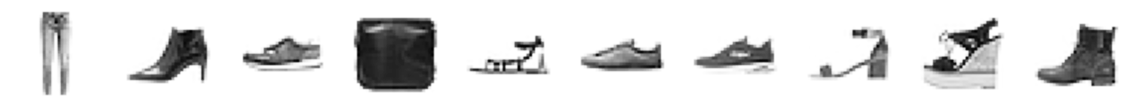

In [21]:
#Plot the images
for batch_idx, x in train_dataloader:
    show_images(x)
    break

# Model definitions

In [22]:
# code for model definitions goes here
class ConvEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, imgChannels =1, featureDim = 32*6*6):
        super(ConvEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 3, stride =1) # 16x30x30
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.maxPool1 = nn.MaxPool2d(2) # 16 x 15 x 15
        self.encConv2 = nn.Conv2d(16, 32, 3, stride =1) # 32 x 13x 13
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.maxPool2 = nn.MaxPool2d(2) # 32x6x6
        
        self.dropout = nn.Dropout(0.5)

        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(featureDim, latent_dim)
        self.sigma_layer = nn.Linear(featureDim, latent_dim)
        
    def forward(self, batch_input):
        
        #Conv Block 1
        h = self.encConv1(batch_input) #[N X H], H = hidden_dim, N = batch_size
        h = self.batchNorm1(h)
        h = nn.ReLU()(self.maxPool1(h))
#         Conv Block 2
        h = self.encConv2(h) #[N X H], H = hidden_dim, N = batch_size
        h = self.batchNorm2(h)
        h = nn.ReLU()(self.maxPool2(h)) 
        h = h.view(-1, 32*6*6)
        
        h = self.dropout(h)
        mu = self.mu_layer(h)
        log_sigma = self.sigma_layer(h)
        
        z = self.reparam(mu, log_sigma)
        
        return z, mu, log_sigma
    
    def reparam(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        
        z = mu + sigma*eps
        
        return z
    #Thus we define a decoder 

class ConvDecoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, output_dim, imgChannels =1, featureDim = 32*28*28):
        super(ConvDecoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(latent_dim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 3)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 3)

        
    def forward(self, z):
        
        h_o = nn.ReLU()(self.decFC1(z))
        
        h_o = h_o.view(-1, 32,28,28)
        
        h_o = nn.ReLU()(self.decConv1(h_o))

        reconstruction = nn.Sigmoid()(self.decConv2(h_o))
        
        return reconstruction
        
#Now we can define the VAE

class ConvVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvVAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, batch_input):
        
        z, mu, log_sigma = self.encoder(batch_input)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_sigma,z
    

In [68]:
class VAEClassifier(nn.Module):
    def __init__(self, encoder, hidden_dim, output_dim, latent_dim):
        super(VAEClassifier, self).__init__()
        
        self.encoder = encoder
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.latent_dim = latent_dim
        
        self.hidden_layer1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.out = nn.Linear(hidden_dim, output_dim)
        
        for params in self.encoder.parameters():
            params.requires_grad = False
            
    def forward(self, batch_input):
        
        z_embd, mu, log_sigma = self.encoder(batch_input)
        #print(z_embd[0].shape)
        h = nn.ReLU()(self.hidden_layer1(z_embd))
        h = nn.ReLU()(self.hidden_layer2(h))
        # N x 5
        output = nn.Softmax(dim=1)(self.out(h))
        
        return output, z_embd

# Training and validation loop

In [41]:
def save_model_checkpoint(path, model, optimizer, overall_loss, overall_reconstruction_loss, overall_kl_loss):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "overall_loss_dict": overall_loss,
                 "overall_reconstruction_dict": overall_reconstruction_loss,
                 "overall_kl_loss_dict": overall_kl_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))
#Defining a saving checkpoint for the classifier
def save_model_checkpoint_for_classifier(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))


In [27]:
def anomaly_detection_evaluation(model, test_loader,device='cpu'):
    losses = []
    targets = []
    with torch.no_grad():
      model.eval()
      for val_data, val_targets in test_loader:
        
        # Forward
        input_tensor = val_data.to(device)
        outputs, mu, log_sigma,z = model.forward(input_tensor)
        #print(outputs)
        loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma,reduce=False)
        losses.append(loss)
        targets.append(val_targets[:,5]) # Targets are 1 for anomalies 0 for anything else
    scores = torch.stack(losses,axis=0).view(-1)
    targets = torch.stack(targets,axis=0).view(-1)
    scores = (scores - scores.min())/(scores.max()-scores.min())
    scores = scores.cpu().detach().numpy() # Convert to numpy
    fpr, tpr, roc_thresholds = roc_curve(targets, scores)
    precision, recall, pr_thresholds = precision_recall_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    return fpr,tpr,precision,recall,roc_auc,pr_auc

In [28]:
# write your training and validation loop here

# training and validation after every epoch
def train_conv(model, train_loader,valid_loader, num_epochs, save_name):
    best_loss = float("Inf") 
    best_pr_auc = 0
    train_overall_loss, train_recons_loss, train_kl_loss,val_pr_auc = [], [], [], []
    cur_step = 0
    train_pred = []
    val_pred = []
    input_dim = 32*32
    batch_size = 260
    cnt = 0

    for epoch in range(num_epochs):
        overall_loss = 0.0 
        overall_recons_loss = 0.0
        overall_kl_loss = 0.0 
        model.train()
        print("Starting epoch " + str(epoch+1))
        for batch_idx, train_data in train_loader:   
            # Forward
            input_tensor = train_data.to(device)
            #input_tensor = input_tensor.view(batch_size,32*32)
            optimizer.zero_grad()
            outputs, mu, log_sigma,z = model.forward(input_tensor)
            loss, reconstruction_loss, kl_loss = loss_criterion(input_tensor, outputs,mu, log_sigma)
            overall_loss += loss.item()
            overall_recons_loss  += reconstruction_loss.item()
            overall_kl_loss += kl_loss
            cnt+=1
            
                
            # Backward and optimize
            loss.backward()
            optimizer.step()   
            
        n_datapoints = cnt * batch_size #cnt gives the no of batches \times the batch_size = total_datapoitns
        avg_overall_loss = overall_loss / n_datapoints
        train_overall_loss.append(avg_overall_loss)
        
        avg_recons_loss = overall_recons_loss/ n_datapoints
        train_recons_loss.append(avg_recons_loss)
        
        avg_kl_loss = overall_kl_loss / n_datapoints
        train_kl_loss.append(avg_kl_loss)
        
        # Validate by doing anomaly prediction on valid set
        
        fpr,tpr,precision,recall,roc_auc,pr_auc = anomaly_detection_evaluation(model,valid_loader,device='cuda:0')
        
        val_pr_auc.append(pr_auc)
        
        print("Train Pass Completed")
        
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_overall_loss, "\tReconstruction Loss:",
              avg_recons_loss, "\tKL Loss:", avg_kl_loss,"\tValidation PR-AUC:", pr_auc)

        if pr_auc > best_pr_auc:
            best_pr_auc = pr_auc
            save_model_checkpoint(save_name, model, optimizer, avg_overall_loss, best_loss,avg_kl_loss)
    
    print("Finished Training") 
    return train_overall_loss, train_recons_loss, train_kl_loss,val_pr_auc


In [58]:

#Defining a training schedule for the classifier
def train_classifier(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs, z_vector = model.forward(input_tensor)
            #print(outputs.shape)
            #print(targets.shape)
            loss = criterion(outputs,targets.to(device))
            # loss = loss/60
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs, z_vector = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                # loss = loss/60
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint_for_classifier(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     


In [29]:
#Loss Criterion

def loss_criterion(x, x_reconstr, mu, log_sigma,reduce=True):
    if reduce:
        reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
        kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
        total_loss = reconstr_loss + kl_loss
    else:
        reconstr_loss =torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=(1,2,3))
        #print(reconstr_loss.shape)
        kl_loss =  0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
        #print(kl_loss.shape)
        total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

In [43]:
def create_loss_plot(obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,model_name,num_epochs,val_pr_aucs,log_scale=True):
    # converted_overall_loss = [tensor.detach().item() for tensor in obtained_train_overall_loss]
    # converted_reconstruction_loss = [tensor.detach().item() for tensor in obtained_train_recons_loss]
    converted_kl_loss = [tensor.detach().item() for tensor in obtained_train_kl_loss]
    fig = plt.gcf()
    fig.set_size_inches(9.5, 3.5)
    plt.plot(range(0,num_epochs),obtained_train_overall_loss, label = "Overall Loss", color = "blue")
    plt.plot(range(0,num_epochs),obtained_train_recons_loss, label = "Reconstruction Loss", color = "red")
    plt.plot(range(0,num_epochs),converted_kl_loss, label = "KL Loss", color = "orange")
    plt.plot(range(0,num_epochs),val_pr_aucs, label = "Validation PR-AUC", color = "black")


    plt.title('Training Metrics', fontsize=14)
    plt.xlabel('#Epochs', fontsize=14)
    plt.grid(True)
    plt.legend()
    scale = ""
    if log_scale:
        scale = '_log'
        plt.yscale("log")
        plt.ylabel('(Log scale)', fontsize=14)
    else:
        plt.ylabel('Loss', fontsize=14)
    
    plt.show()
    fig.savefig(f'{model_name}_{num_epochs}{scale}.png')
    fig = plt.gcf()
def create_loss_plot_cl(obtained_train_loss, obtained_val_loss, model_name,num_epochs,log_scale=True):
    converted_train_loss = [tensor.detach().item() for tensor in obtained_train_loss]
    converted_val_loss = [tensor.detach().item() for tensor in obtained_val_loss]
    #converted_kl_loss = [tensor.detach().item() for tensor in obtained_train_kl_loss]
    fig = plt.gcf()
    fig.set_size_inches(9.5, 3.5)
    plt.plot(range(0,num_epochs),converted_train_loss, label = "Train Loss", color = "blue")
    plt.plot(range(0,num_epochs),converted_val_loss, label = "Validation Loss", color = "red")
    #plt.plot(range(0,num_epochs),converted_kl_loss, label = "KL Loss", color = "orange")


    plt.title('Loss Vs Epochs {VAEClassifier Training}', fontsize=14)
    plt.xlabel('#Epochs', fontsize=14)
    plt.grid(True)
    plt.legend()
    scale = ""
    if log_scale:
        scale = '_log'
        plt.yscale("log")
        plt.ylabel('Loss (Log scale)', fontsize=14)
    else:
        plt.ylabel('Loss', fontsize=14)
    
    plt.show()
    fig.savefig(f'{model_name}_{num_epochs}{scale}.png')
    fig = plt.gcf()

In [64]:
# perform training
device = "cuda:0"

encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 10).cuda()
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 10, output_dim = 32*32).cuda()

conv_vae = ConvVAE(encoder = encoder, decoder = decoder).cuda()

optimizer = optim.Adam(conv_vae.parameters(), lr = 6e-4)
save_name = f'Conv_VAE_modified_200.pt'
epochs = 200
obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,val_pr_aucs = train_conv(conv_vae, train_dataloader,
                                                                                        
                                                                                        val_dataloader,epochs , save_name )


Starting epoch 1
Train Pass Completed
	Epoch 1 	Average Loss:  113.15531403996394 	Reconstruction Loss: 100.17264227764423 	KL Loss: tensor(12.9827, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.2593507753690968
Model Saved to ==> Conv_VAE_modified_200.pt
Starting epoch 2
Train Pass Completed
	Epoch 2 	Average Loss:  25.236163987379808 	Reconstruction Loss: 19.432546424278847 	KL Loss: tensor(5.8036, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.4454260941742215
Model Saved to ==> Conv_VAE_modified_200.pt
Starting epoch 3
Train Pass Completed
	Epoch 3 	Average Loss:  13.07688196113782 	Reconstruction Loss: 9.645859256059696 	KL Loss: tensor(3.4310, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5172374126603505
Model Saved to ==> Conv_VAE_modified_200.pt
Starting epoch 4
Train Pass Completed
	Epoch 4 	Average Loss:  8.840149601862981 	Reconstruction Loss: 6.523046428973858 	KL Loss: tensor(2.3171, device='cuda:0', grad_fn=<DivBackward0>

Train Pass Completed
	Epoch 35 	Average Loss:  0.7482189597999657 	Reconstruction Loss: 0.5325494805975275 	KL Loss: tensor(0.2157, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5823104974979294
Starting epoch 36
Train Pass Completed
	Epoch 36 	Average Loss:  0.7261018290723491 	Reconstruction Loss: 0.5162588412293002 	KL Loss: tensor(0.2098, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.598182084673331
Starting epoch 37
Train Pass Completed
	Epoch 37 	Average Loss:  0.7040881885679249 	Reconstruction Loss: 0.5007613923832186 	KL Loss: tensor(0.2033, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.6038018798038578
Model Saved to ==> Conv_VAE_modified_200.pt
Starting epoch 38
Train Pass Completed
	Epoch 38 	Average Loss:  0.6853568228903087 	Reconstruction Loss: 0.4870022264241207 	KL Loss: tensor(0.1984, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.6062947979102254
Model Saved to ==> Conv_VAE_modified_200.pt
Starting ep

Train Pass Completed
	Epoch 71 	Average Loss:  0.3563401206895822 	Reconstruction Loss: 0.25090551652009413 	KL Loss: tensor(0.1054, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5995201671765719
Starting epoch 72
Train Pass Completed
	Epoch 72 	Average Loss:  0.3513494912171975 	Reconstruction Loss: 0.24710432994875134 	KL Loss: tensor(0.1042, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.582678439326696
Starting epoch 73
Train Pass Completed
	Epoch 73 	Average Loss:  0.34573139643292283 	Reconstruction Loss: 0.2434135749905328 	KL Loss: tensor(0.1023, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5958746837061772
Starting epoch 74
Train Pass Completed
	Epoch 74 	Average Loss:  0.34122033209215824 	Reconstruction Loss: 0.2397841274079067 	KL Loss: tensor(0.1014, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5723768154086138
Starting epoch 75
Train Pass Completed
	Epoch 75 	Average Loss:  0.33656337314703527 	Reconstru

Train Pass Completed
	Epoch 106 	Average Loss:  0.23484145263317535 	Reconstruction Loss: 0.16442229152729274 	KL Loss: tensor(0.0704, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.591068789615754
Starting epoch 107
Train Pass Completed
	Epoch 107 	Average Loss:  0.23311118630930985 	Reconstruction Loss: 0.16294047654986296 	KL Loss: tensor(0.0702, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5762802948026504
Starting epoch 108
Train Pass Completed
	Epoch 108 	Average Loss:  0.23095572864499866 	Reconstruction Loss: 0.16168083951683807 	KL Loss: tensor(0.0693, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5769847443412581
Starting epoch 109
Train Pass Completed
	Epoch 109 	Average Loss:  0.228759792675161 	Reconstruction Loss: 0.16009669536625573 	KL Loss: tensor(0.0687, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5976322701081359
Starting epoch 110
Train Pass Completed
	Epoch 110 	Average Loss:  0.22648633836866258

Train Pass Completed
	Epoch 142 	Average Loss:  0.17396527013644367 	Reconstruction Loss: 0.12118078666182794 	KL Loss: tensor(0.0528, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.592955561270818
Starting epoch 143
Train Pass Completed
	Epoch 143 	Average Loss:  0.17276282138834723 	Reconstruction Loss: 0.12031842727209689 	KL Loss: tensor(0.0524, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.6066209863012356
Starting epoch 144
Train Pass Completed
	Epoch 144 	Average Loss:  0.17125845636873163 	Reconstruction Loss: 0.11935285467164129 	KL Loss: tensor(0.0519, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5995153588782652
Starting epoch 145
Train Pass Completed
	Epoch 145 	Average Loss:  0.17006219809453746 	Reconstruction Loss: 0.11829591430340268 	KL Loss: tensor(0.0518, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.594713575870904
Starting epoch 146
Train Pass Completed
	Epoch 146 	Average Loss:  0.1691427654109589

Train Pass Completed
	Epoch 177 	Average Loss:  0.13893476256926338 	Reconstruction Loss: 0.09643323459484328 	KL Loss: tensor(0.0425, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.588959318870904
Starting epoch 178
Train Pass Completed
	Epoch 178 	Average Loss:  0.13826877867650036 	Reconstruction Loss: 0.0959540471742147 	KL Loss: tensor(0.0423, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5880578578353384
Starting epoch 179
Train Pass Completed
	Epoch 179 	Average Loss:  0.13740398118134267 	Reconstruction Loss: 0.09550998668400167 	KL Loss: tensor(0.0419, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.5902886630907169
Starting epoch 180
Train Pass Completed
	Epoch 180 	Average Loss:  0.13638821374616053 	Reconstruction Loss: 0.0946913592998798 	KL Loss: tensor(0.0417, device='cuda:0', grad_fn=<DivBackward0>) 	Validation PR-AUC: 0.6193770674150938
Starting epoch 181
Train Pass Completed
	Epoch 181 	Average Loss:  0.13581723589234487

In [69]:
# Train the classifier on top of the freezed pre-trained encoder
pretrained_encoder = conv_vae.encoder

device = 'cuda:0'
VAE_classifier = VAEClassifier(encoder = pretrained_encoder, hidden_dim = 512, output_dim = 5, latent_dim = 10).cuda()

classifier_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(VAE_classifier.parameters(), lr = 3e-4)
save_name = f'VAE_classifier.pt'
epochs = 200

obtained_train_loss, obtained_val_loss = train_classifier(VAE_classifier, 
                                                      cl_train_dataloader, cl_valid_dataloader, classifier_criterion, epochs, save_name)


Starting epoch 1
Train Pass Completed
Epoch [1/200],Train Loss: 1.2681, Valid Loss: 1.10017431
Model Saved to ==> VAE_classifier.pt
Starting epoch 2
Train Pass Completed
Epoch [2/200],Train Loss: 1.0847, Valid Loss: 1.06310391
Model Saved to ==> VAE_classifier.pt
Starting epoch 3
Train Pass Completed
Epoch [3/200],Train Loss: 1.0728, Valid Loss: 1.05104542
Model Saved to ==> VAE_classifier.pt
Starting epoch 4
Train Pass Completed
Epoch [4/200],Train Loss: 1.0627, Valid Loss: 1.05238438
Starting epoch 5
Train Pass Completed
Epoch [5/200],Train Loss: 1.0529, Valid Loss: 1.03283072
Model Saved to ==> VAE_classifier.pt
Starting epoch 6
Train Pass Completed
Epoch [6/200],Train Loss: 1.0521, Valid Loss: 1.04147720
Starting epoch 7
Train Pass Completed
Epoch [7/200],Train Loss: 1.0421, Valid Loss: 1.03522527
Starting epoch 8
Train Pass Completed
Epoch [8/200],Train Loss: 1.0388, Valid Loss: 1.02577639
Model Saved to ==> VAE_classifier.pt
Starting epoch 9
Train Pass Completed
Epoch [9/200],Tra

Train Pass Completed
Epoch [81/200],Train Loss: 1.0193, Valid Loss: 1.00880373
Starting epoch 82
Train Pass Completed
Epoch [82/200],Train Loss: 1.0110, Valid Loss: 1.00673771
Starting epoch 83
Train Pass Completed
Epoch [83/200],Train Loss: 1.0289, Valid Loss: 1.01436055
Starting epoch 84
Train Pass Completed
Epoch [84/200],Train Loss: 1.0213, Valid Loss: 1.01625371
Starting epoch 85
Train Pass Completed
Epoch [85/200],Train Loss: 1.0207, Valid Loss: 1.02308786
Starting epoch 86
Train Pass Completed
Epoch [86/200],Train Loss: 1.0240, Valid Loss: 1.00597668
Starting epoch 87
Train Pass Completed
Epoch [87/200],Train Loss: 1.0079, Valid Loss: 1.01749957
Starting epoch 88
Train Pass Completed
Epoch [88/200],Train Loss: 1.0189, Valid Loss: 1.00829220
Starting epoch 89
Train Pass Completed
Epoch [89/200],Train Loss: 1.0157, Valid Loss: 1.00079298
Starting epoch 90
Train Pass Completed
Epoch [90/200],Train Loss: 1.0271, Valid Loss: 1.00931203
Starting epoch 91
Train Pass Completed
Epoch [91

Train Pass Completed
Epoch [165/200],Train Loss: 1.0198, Valid Loss: 1.00211036
Starting epoch 166
Train Pass Completed
Epoch [166/200],Train Loss: 1.0097, Valid Loss: 1.00806129
Starting epoch 167
Train Pass Completed
Epoch [167/200],Train Loss: 1.0168, Valid Loss: 1.01947498
Starting epoch 168
Train Pass Completed
Epoch [168/200],Train Loss: 1.0158, Valid Loss: 0.99701440
Starting epoch 169
Train Pass Completed
Epoch [169/200],Train Loss: 1.0232, Valid Loss: 1.01194167
Starting epoch 170
Train Pass Completed
Epoch [170/200],Train Loss: 1.0097, Valid Loss: 1.00165141
Starting epoch 171
Train Pass Completed
Epoch [171/200],Train Loss: 1.0154, Valid Loss: 1.00668561
Starting epoch 172
Train Pass Completed
Epoch [172/200],Train Loss: 1.0189, Valid Loss: 1.00429320
Starting epoch 173
Train Pass Completed
Epoch [173/200],Train Loss: 1.0100, Valid Loss: 1.00856590
Starting epoch 174
Train Pass Completed
Epoch [174/200],Train Loss: 1.0070, Valid Loss: 1.00728762
Starting epoch 175
Train Pass

# Inspection, Validation, and Analysis

In [100]:

# Generating the images from the sample space
def reconstruct_images(model, data_loader,device='cuda:0'):
    generated_image = []
    original_image = []
    with torch.no_grad():
        model.eval()
        for batch_idx, image in data_loader:
            input_tensor = image.to(device)
            original_image.append(input_tensor)
            outputs = model.forward(input_tensor)
            generated_image.append(outputs)

        return generated_image, original_image

def compute_tsne(model, test_loader,device='cpu'):
  embeddings = []
  actual_targets = []
  with torch.no_grad():
    model.eval()

    for input, target in test_loader:
        input_tensor = input.to(device)
        outputs, mu, log_sigma,z = model.forward(input_tensor)
        actual_targets.append(torch.argmax(target,axis=1))
        #print(len(target))
        #print(z.shape)
        #print(torch.argmax(target,axis=1).shape)
        embeddings.append(z)
    tsne = TSNE(2,perplexity=25,n_jobs=-1,random_state=0)
    actual_targets = torch.stack(actual_targets,axis=0).view(1000,-1).detach().numpy()
    embeddings = torch.stack(embeddings,axis=0).view(1000,-1).detach().numpy()
    #print(embeddings.shape)
    #print(actual_targets.shape)
    return tsne.fit_transform(np.array(embeddings)),actual_targets

def plot_tsne(tsne_embeds, labels):
  fig,ax = plt.subplots(figsize=(10,10))
  g = sns.scatterplot(tsne_embeds[:,0],tsne_embeds[:,1],hue=labels.flatten(),ax=ax,palette='colorblind')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def evaluate_test(model, test_loader, criterion, device):
  batch_test_loss = []
  predictions = []
  actual_targets = []
  input_list = []
  test_running_loss = 0

  with torch.no_grad():
    model.eval()

    for input, target in test_loader:
      input_tensor = input.to(device)
      input_list.append(input_tensor)
      outputs, z_embd = model.forward(input_tensor)
      predictions.append(outputs)
      actual_targets.append(target)
      loss = criterion(outputs, target.to(device))
      test_running_loss += loss.item()
      batch_test_loss.append(loss)
    avg_test_loss = test_running_loss/len(test_loader)
    print(f'The Average Test Loss is {avg_test_loss}')
    

    return predictions, actual_targets, batch_test_loss

In [98]:
# Load model for evaluation
encoder = ConvEncoder(input_dim = 32*32, hidden_dim = 500, latent_dim = 10)
decoder = ConvDecoder(hidden_dim = 500, latent_dim = 10, output_dim = 32*32)

model = ConvVAE(encoder = encoder, decoder = decoder)
checkpoint = torch.load('Conv_VAE_modified_200.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

### Detecting out of distribution data

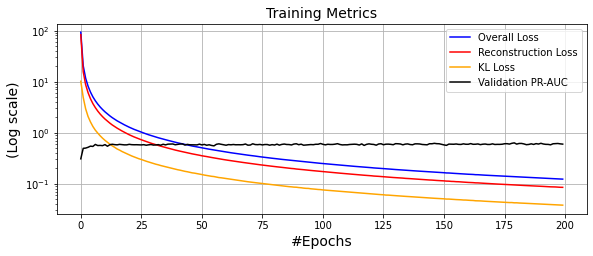

<Figure size 432x288 with 0 Axes>

In [39]:
#Plot for ConvVAE
create_loss_plot(obtained_train_overall_loss, obtained_train_recons_loss, obtained_train_kl_loss,"ConvVAE",epochs,val_pr_aucs,log_scale=True)

roc_auc=0.9198846153846153


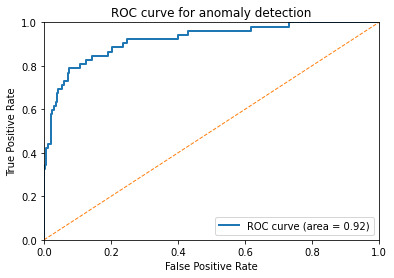

pr_auc=0.612183160273342


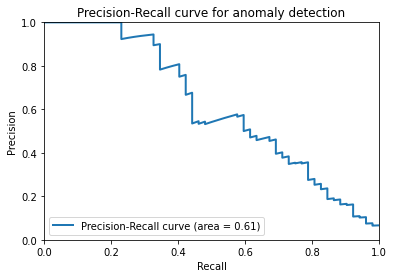

In [99]:
# Visualization code taken from the practical
fpr,tpr,precision,recall,roc_auc,pr_auc = anomaly_detection_evaluation(model,test_dataloader)

print(f'{roc_auc=}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


print(f'{pr_auc=}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()

### Low dimensional description of the data

/home/lostarious/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lostarious/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lostarious/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


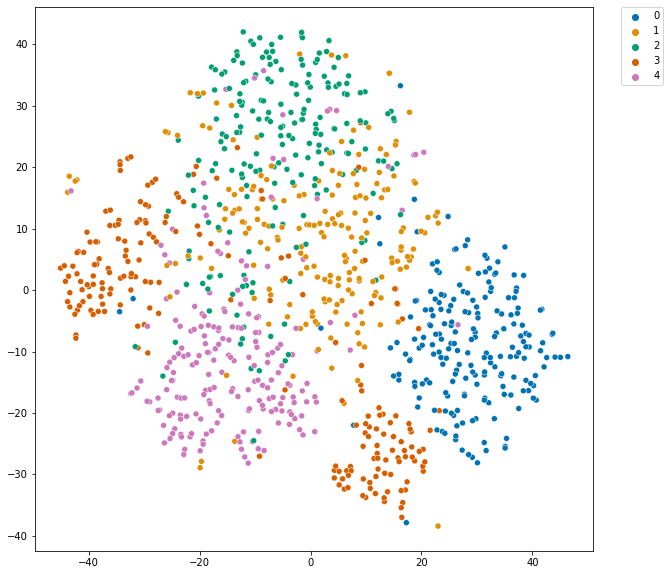

In [101]:
tsne_embeds,targets = compute_tsne(model,cl_test_dataloader)
plot_tsne(tsne_embeds, targets)

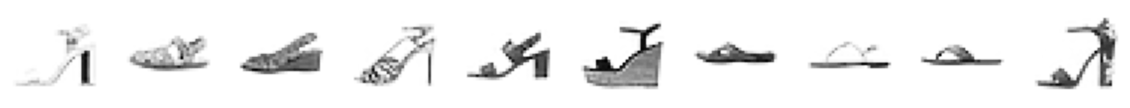

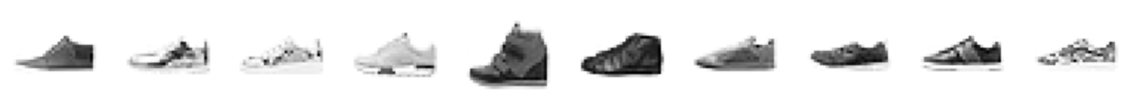

In [114]:
# Try to see which images we are trying to differentiate between (classses 1 and 2)
c1_idx = np.array(np.where(test_labels_set2[:,1] ==1)).flatten()
c2_idx = np.array(np.where(test_labels_set2[:,2] ==1)).flatten()


c1_samples = SubsetRandomSampler(c1_idx)
c2_samples = SubsetRandomSampler(c2_idx)

cl_test_plotc1 = DataLoader(dataset = cl_test_dataset,  batch_size = 10, sampler=c1_samples)
for x,target in cl_test_plotc1:
    show_images(x)
    break
cl_test_plotc2 = DataLoader(dataset = cl_test_dataset,  batch_size = 10, sampler=c2_samples)
for x,target in cl_test_plotc2:
    show_images(x)
    break

### Classifying data points

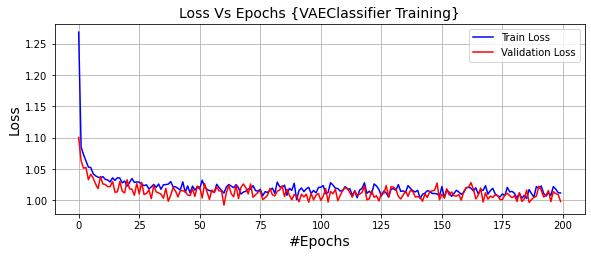

<Figure size 432x288 with 0 Axes>

In [70]:
# Plot for the classifier
create_loss_plot_cl(obtained_train_loss, obtained_val_loss, "VAEClassifier",epochs,log_scale=False)

In [94]:
preds, targs, obtained_test_loss = evaluate_test(VAE_classifier, cl_test_dataloader, criterion = classifier_criterion, device = "cuda:0")

The Average Test Loss is 1.0181567919254304
